In [106]:
import os
import re

pattern = re.compile("(.*?)_512x288_(.*)_psnr.log")
def extract_info(path):
    match = pattern.match(path)
    return (match.group(1), match.group(2))



[(root, _, files), *_] = os.walk("logs")
files = [(f, extract_info(f)) for f in files]
print("found", len(files), "files")

groups = groupby(sorted(files), key=lambda x: x[1])

logs = []
for invid, triples in groups:
    for (infile, (invid, codec)) in triples:
        with open(f"logs/{infile}") as infp:
            logs.append((invid, codec, infp.readlines()))

print(len(logs))

found 20 files
20


20


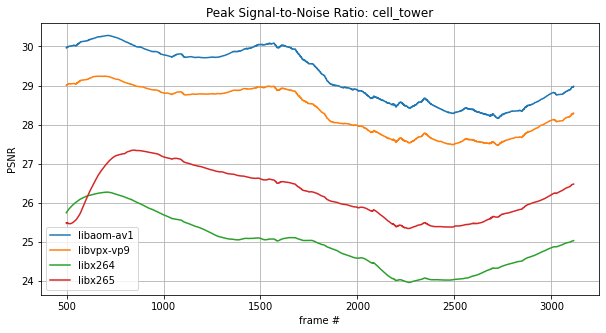

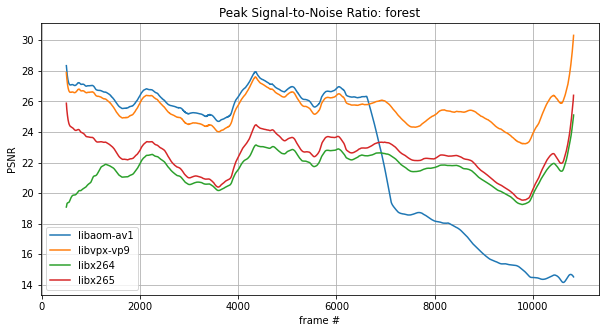

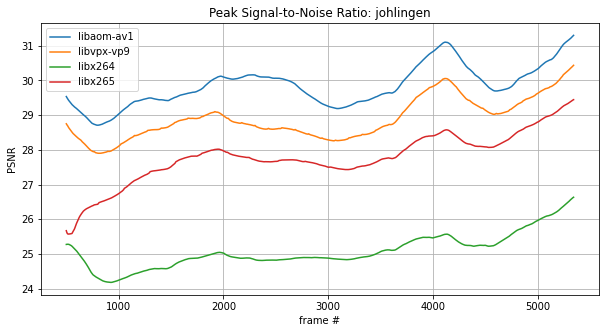

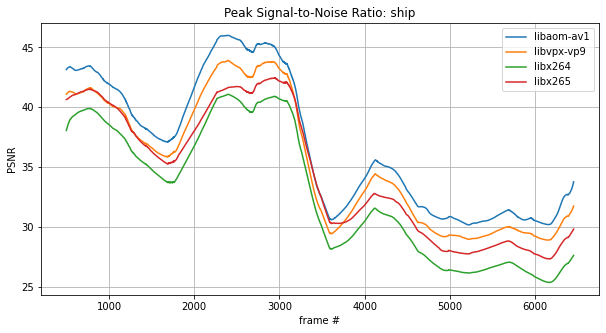

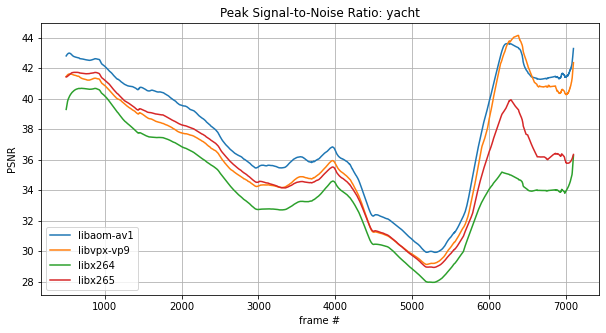

In [120]:
import re
from pandas import DataFrame
import matplotlib.pyplot as plt
from itertools import groupby
# n:1 mse_avg:23.20 mse_y:29.59 mse_u:8.02 mse_v:12.82 psnr_avg:34.48 psnr_y:33.42 psnr_u:39.09 psnr_v:37.05 
pattern = re.compile("n:(\d+) mse_avg:(\d+\.\d+) .* psnr_avg:(\d+\.\d+|inf)")

def read_log(loglines):
    matches = [pattern.match(logline) for logline in loglines]
    metrics = [(float(match.group(2)), float(match.group(3))) for match in matches]
    return DataFrame(metrics, columns=[f"mse", f"psnr"])

dataframes = [(invid, codec, read_log(loglines)) for (invid, codec, loglines) in logs]

groups = groupby(dataframes, key=lambda x: x[0])

for (invid, triples) in groups:
    triples = list(triples)
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for (invid, codec, df) in triples:
        df[codec] = df[["psnr"]]
        df[codec].rolling(500).mean().plot(ax=ax, title=f"Peak Signal-to-Noise Ratio: {invid}", legend=True, grid=True, xlabel="frame #", ylabel="PSNR")
    # fig.savefig(f"psnr_{invid}.jpg")
print(len(dataframes))